# FIN 514_Project_2_VMENDAY2

## Crank-Nicolson Finite Difference Model: 
*Auto-Callable Barrier Notes with Contingent Coupons (S&P 500)*

https://www.sec.gov/Archives/edgar/data/927971/000121465922011753/b930221424b2.htm


In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

## Inputs

In [80]:
# ENTER INPUT FOR: start_step

Face = 1000
jmax = 100 #Number of S steps
imax = 398*3 #Number of t steps
S0 =  3719.04
K = 2789.28
Barr = 2789.28
sigma = 0.25855
r1 = 0.042557
r2 = 0.042557
q = .01814
Tm = 401/365
Tv = 398/365
tcp = [36/365,66/365,97/365,128/365,156/365,187/365,217/365,248/365,
278/365,309/365,340/365,370/365,401/365]
tob = [34/365,64/365,95/365,126/365,154/365,182/365,215/365,246/365,
276/365,307/365,338/365,368/365,398/365]
cpn = .116
imax = 398*3
jmaxmin = 50
jmaxmax = 500
jmaxstep = 50
tauto = 182/365

SL = 0 #Minimum S value
SU = 2.5*S0 #Maximum S value

## Crank-Nicolson Finite Difference Model

In [51]:
# Sensitivity analysis wrt volatility

vol_array = np.arange(.05, .8, .05)
jmax = 500
Result_arr = [fun1(i) for i in vol_array]
Result_arr1 = [i[0] for i in Result_arr]
df2 = pd.DataFrame({'Volatility': vol_array, 'Option value': Result_arr1})
df2

,Volatility,Option value
0,0.05,1054.079280
1,0.10,1032.868207
2,0.15,1008.832123
3,0.20,982.591749
4,0.25,956.137497
5,0.30,930.354902
6,0.35,905.439131
7,0.40,881.361359
8,0.45,858.037370
9,0.50,835.388278


In [89]:
def fun1(sigma):
    return CNFD_1(Face, S0, K, Barr, Tv, Tm, tcp, tob, tauto, cpn, r1, r2, q, sigma, SU, imax, jmax)

In [90]:
jmax = 450
fun1(sigma)

[951.6449438819787]

In [84]:
CNFD_discbarrier(Face, S0, K, Barr, Tv, Tm, tcp, tob, tauto, cpn, r1, r2, q, sigma, SU, 450, 500, 50, imax)


[{'S_steps': 450,
  't_steps': 1194,
  'CN': 975.5414557915095,
  'Barrier Lambda': 1.000000000000006}]

In [56]:
df

,S_steps,t_steps,CN,Barrier Lambda,error_cn
0,50,1194,973.090286,1.0,-26.909714
1,100,1194,974.530305,1.0,-25.469695
2,150,1194,974.975229,1.0,-25.024771
3,200,1194,975.191186,1.0,-24.808814
4,250,1194,975.318677,1.0,-24.681323
5,300,1194,975.402800,1.0,-24.597200
6,350,1194,975.462462,1.0,-24.537538
7,400,1194,975.506974,1.0,-24.493026
8,450,1194,975.541456,1.0,-24.458544


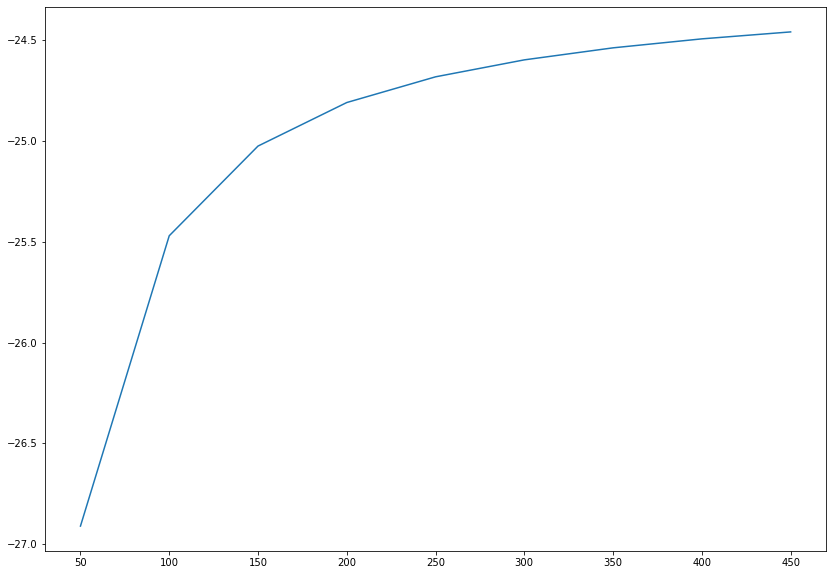

In [55]:
cnfd = CNFD_discbarrier(Face, S0, K, Barr, Tv, Tm, tcp, tob, tauto, cpn, r1, r2, q, sigma, SU, jmaxmin, jmaxmax, jmaxstep, imax)
exact = 1000
df = pd.DataFrame.from_dict(cnfd)
df['error_cn'] = df["CN"] - exact 
df.to_csv("cn.csv", index=False)
plt.figure(figsize=(14,10))
plt.plot(df['S_steps'], df['error_cn'], '-', markersize=3)
plt.savefig('cnbarr1.png')
plt.show()

## C-N Function

In [17]:

def CNFD_discbarrier(Face, S0, K, Barr, Tv, Tm, tcp, tob, tauto, cpn, r1, r2, q, sigma, SU, jmaxmin, jmaxmax, jmaxstep, imax):
    
    #LIST TO SAVE RESULTS
    #Assumes that SL= 0, can be relaxed, see notes for updates A, B, C values in this case
    
    cnfddb_result = []
    
    for jmax in range(jmaxmin, jmaxmax, jmaxstep): 
    
    # CREATE TWO DIMENSIONAL ARRAY OF SIZE [imax+1,jmax+1] TO STORE V AT ALL STEPS
    # V[imax, jmax]
    
        V1 = np.zeros([imax+1, jmax+1])


    # CREATE ONE DIMENSIONAL ARRAY OF SIZE [jmax+1] TO STORE A, B, C VALUES AT ALL STEPS
    # A[jmax], B[jmax], C[jmax] 
    
        A = np.zeros([jmax+1])
        B = np.zeros([jmax+1])
        C = np.zeros([jmax+1])
        D = np.zeros([jmax+1])
        alpha = np.zeros([jmax+1])
        CN_S = np.zeros([jmax+1])
    
    # Set up time and S steps
    
        dt = Tv / imax
        dS = SU/jmax
        
        jb = int(Barr/dS)
        if (jb*dS > Barr): jb = jb-1 
        
        ji = int(S0/dS)
        if (ji*dS > S0): ji = ji-1
            
        icp1  = [j/dt for j in tcp] # coupon payment dates
        icp   = [int(j) for j in icp1] # nearest time point to coupon payment dates
        inc   = [j for j in icp if j<tauto]
        
        iob1  = [j/dt for j in tob] # observation date
        iob   = [int(j) for j in iob1] # nearest time point to observation date
        
        iauto    = [j for j in iob if j>=tauto ] # nearest time points to autocallable observation dates 
        ibarrier = iob
      
        
    # CALCULATE OPTION VALUES AND PROBABILITIES
    # Start at the last step number because we are going to be moving backwards from times step imax to times step 0
    
    ####################################################################
    # CASE-1:--------- TRIGGER EVENT HAS OCCURED (V1)-------------------
    ####################################################################
    
        i = imax 
        
        for j in range(0, jmax+1):    
    # Then, calculate the value of the option at that exact position within the binomial tree
    # Also calculate the probabilities A, B, C
           
            if j>ji:
                V1[i, j] = Face*(1+cpn)*np.exp(-r2*(Tm-Tv))
            elif j>jb: 
                V1[i, j] = (dS*j/S0)*Face*(1+cpn)*np.exp(-r2*(Tm-Tv))
            else: V1[i, j] = (dS*j/S0)*Face*np.exp(-r2*(Tm-Tv))

    #Now go back in time
        for i in range(imax-1, -1, -1):

            if (i in ibarrier):    
                #Lower boundary condition in matrix terms
                A[0] = 0
                B[0] = 1
                C[0] = 0
                D[0] = 0
    
                #regular D values
                for j in range(1, jmax, 1):
                    A[j] = 0.25*sigma**2*j**2 - 0.25*(r1-q)*j
                    B[j] = -1/dt-0.5*r1-0.5*sigma**2*j**2
                    C[j] = 0.25*sigma**2*j**2 + 0.25*(r1-q)*j
                    D1 = -V1[i+1,j-1]*(0.25*sigma**2*j**2-0.25*(r1-q)*j)
                    D2 = -V1[i+1,j]*(1/dt-0.5*r1-0.5*sigma**2*j**2)
                    D3 = -V1[i+1,j+1]*(0.25*sigma**2*j**2+0.25*(r1-q)*j)
                    D[j] = D1+D2+D3
            
                #Upper boundary condition in matrix terms
                A[jmax] = 0
                B[jmax] = 1
                C[jmax] = 0
                
                TNCi = tcp[iob.index(i)+1]
                
                if (i in iauto):
                    D[jmax] = Face*(1+cpn)*np.exp(-r2*(TNCi-dt*i))
                if (i in inc):
                    cpk = np.zeros(5)
                    for k in range(5):
                        if inc[k] >i:
                            cpk[k] = Face*cpn*np.exp(-r2(inc[k]*dt-i*dt)) # present value of coupons 

                    D[jmax] = Face*(1+cpn)*np.exp(-r2*(tauto-dt*i))*(sum(cpk))
            
                alpha[0] = B[0]
                CN_S[0] = D[0]
                for j in range(1, jmax+1, 1):
                    alpha[j] = B[j]-(A[j]*C[j-1])/alpha[j-1]
                    CN_S[j] = D[j]-(A[j]*CN_S[j-1])/alpha[j-1]  
                V1[i,jmax] = CN_S[jmax]/alpha[jmax]
                for j in range(jmax-1,-1,-1):
                    V1[i,j] = (CN_S[j]-C[j]*V1[i,j+1])/alpha[j]
            
            else:
            
                #Lower boundary condition in matrix terms
                A[0] = 0
                B[0] = 1
                C[0] = 0
                D[0] = 0

                #regular D values
                for j in range(1, jmax, 1):
                    A[j] = 0.25*sigma**2*j**2 - 0.25*(r1-q)*j
                    B[j] = -1/dt-0.5*r1-0.5*sigma**2*j**2
                    C[j] = 0.25*sigma**2*j**2 + 0.25*(r1-q)*j
                    D1 = -V1[i+1,j-1]*(0.25*sigma**2*j**2-0.25*(r1-q)*j)
                    D2 = -V1[i+1,j]*(1/dt-0.5*r1-0.5*sigma**2*j**2)
                    D3 = -V1[i+1,j+1]*(0.25*sigma**2*j**2+0.25*(r1-q)*j)
                    D[j] = D1+D2+D3

                #Upper boundary condition in matrix terms
                A[jmax] = 0
                B[jmax] = 1
                C[jmax] = 0
                D[jmax] = Face*(1+cpn)
                alpha[0] = B[0]
                CN_S[0] = D[0]
                for j in range(1, jmax+1, 1):
                    alpha[j] = B[j]-(A[j]*C[j-1])/alpha[j-1]
                    CN_S[j] = D[j]-(A[j]*CN_S[j-1])/alpha[j-1]  
                V1[i,jmax] = CN_S[jmax]/alpha[jmax]
                for j in range(jmax-1,-1,-1):
                    V1[i,j] = (CN_S[j]-C[j]*V1[i,j+1])/alpha[j]
                    
    ####################################################################
    # CASE-2:--------- TRIGGER EVENT HAS NOT OCCURED (V2)---------------
    ####################################################################
    
         
        V2 = np.zeros([imax+1, jmax+1])

    # CREATE ONE DIMENSIONAL ARRAY OF SIZE [jmax+1] TO STORE A, B, C VALUES AT ALL STEPS
    # A[jmax], B[jmax], C[jmax] 
    
        A = np.zeros([jmax+1])
        B = np.zeros([jmax+1])
        C = np.zeros([jmax+1])
        D = np.zeros([jmax+1])
        alpha = np.zeros([jmax+1])
        CN_S = np.zeros([jmax+1])
        
        i = imax
        
        for j in range(0, jmax+1):    
    # Then, calculate the value of the option at that exact position within the binomial tree
    # Also calculate the probabilities A, B, C
           
            V2[i, j] = Face*(1+cpn)*np.exp(-r2*(Tm-Tv))
            

    #Now go back in time
        for i in range(imax-1, -1, -1):

            if (i in ibarrier):    
                #Lower boundary condition in matrix terms
                A[0] = 0
                B[0] = 1
                C[0] = 0
                D[0] = 0
    
                #regular D values
                for j in range(1, ji+1, 1):
                    A[j] = 0
                    B[j] = 1
                    C[j] = 0

                    D[j] = V1[i,j]
                    
                for j in range(ji+1, jmax, 1):
                    A[j] = 0.25*sigma**2*j**2 - 0.25*(r1-q)*j
                    B[j] = -1/dt-0.5*r1-0.5*sigma**2*j**2
                    C[j] = 0.25*sigma**2*j**2 + 0.25*(r1-q)*j
                    D1 = -V2[i+1,j-1]*(0.25*sigma**2*j**2-0.25*(r1-q)*j)
                    D2 = -V2[i+1,j]*(1/dt-0.5*r1-0.5*sigma**2*j**2)
                    D3 = -V2[i+1,j+1]*(0.25*sigma**2*j**2+0.25*(r1-q)*j)
                    D[j] = D1+D2+D3
            
                #Upper boundary condition in matrix terms
                A[jmax] = 0
                B[jmax] = 1
                C[jmax] = 0
                
                TNCi = tcp[iob.index(i)+1]
                
                if (i in iauto):
                    D[jmax] = Face*(1+cpn)*np.exp(-r2*(TNCi-dt*i))
                if (i in inc):
                    cpk = np.zeros(5)
                    for k in range(5):
                        if inc[k] >i:
                            cpk[k] = Face*cpn*np.exp(-r2(inc[k]*dt-i*dt)) # present value of coupons 

                    D[jmax] = Face*(1+cpn)*np.exp(-r2*(tauto-dt*i))*(sum(cpk))
            
                alpha[0] = B[0]
                CN_S[0] = D[0]
                for j in range(1, jmax+1, 1):
                    alpha[j] = B[j]-(A[j]*C[j-1])/alpha[j-1]
                    CN_S[j] = D[j]-(A[j]*CN_S[j-1])/alpha[j-1]  
                V2[i,jmax] = CN_S[jmax]/alpha[jmax]
                for j in range(jmax-1,-1,-1):
                    V2[i,j] = (CN_S[j]-C[j]*V2[i,j+1])/alpha[j]
            
            else:
            
                #Lower boundary condition in matrix terms
                A[0] = 0
                B[0] = 1
                C[0] = 0
                D[0] = 0

                #regular D values
                for j in range(1, ji+1, 1):
                    A[j] = 0
                    B[j] = 1
                    C[j] = 0

                    D[j] = V1[i,j]
                    
                for j in range(ji+1, jmax, 1):
                    A[j] = 0.25*sigma**2*j**2 - 0.25*(r1-q)*j
                    B[j] = -1/dt-0.5*r1-0.5*sigma**2*j**2
                    C[j] = 0.25*sigma**2*j**2 + 0.25*(r1-q)*j
                    D1 = -V2[i+1,j-1]*(0.25*sigma**2*j**2-0.25*(r1-q)*j)
                    D2 = -V2[i+1,j]*(1/dt-0.5*r1-0.5*sigma**2*j**2)
                    D3 = -V2[i+1,j+1]*(0.25*sigma**2*j**2+0.25*(r1-q)*j)
                    D[j] = D1+D2+D3

                #Upper boundary condition in matrix terms
                A[jmax] = 0
                B[jmax] = 1
                C[jmax] = 0
                D[jmax] = Face*(1+cpn)
                alpha[0] = B[0]
                CN_S[0] = D[0]
                for j in range(1, jmax+1, 1):
                    alpha[j] = B[j]-(A[j]*C[j-1])/alpha[j-1]
                    CN_S[j] = D[j]-(A[j]*CN_S[j-1])/alpha[j-1]  
                V2[i,jmax] = CN_S[jmax]/alpha[jmax]
                for j in range(jmax-1,-1,-1):
                    V2[i,j] = (CN_S[j]-C[j]*V2[i,j+1])/alpha[j]
                
    # RELAY OUTPUTS TO DICTIONARY
        jcritreal = S0/dS
        jcrit = int(jcritreal)
        jcritB = int(Barr/dS)+1
        Vcrit = V2[0,jcrit]+ (S0 - jcrit * dS) / (dS) * (V2[0,jcrit+1] - V2[0,jcrit])
        Blambda = (jcritB*dS - Barr)/dS
        output = {'S_steps': jmax, 't_steps': imax, 'CN': Vcrit, 'Barrier Lambda': Blambda}
        cnfddb_result.append(output)

    return cnfddb_result


In [85]:

def CNFD_1(Face, S0, K, Barr, Tv, Tm, tcp, tob, tauto, cpn, r1, r2, q, sigma, SU, imax, jmax):
    
    #LIST TO SAVE RESULTS
    #Assumes that SL= 0, can be relaxed, see notes for updates A, B, C values in this case
    
    cnfddb_result = []
    


# CREATE TWO DIMENSIONAL ARRAY OF SIZE [imax+1,jmax+1] TO STORE V AT ALL STEPS
# V[imax, jmax]

    V1 = np.zeros([imax+1, jmax+1])


# CREATE ONE DIMENSIONAL ARRAY OF SIZE [jmax+1] TO STORE A, B, C VALUES AT ALL STEPS
# A[jmax], B[jmax], C[jmax] 

    A = np.zeros([jmax+1])
    B = np.zeros([jmax+1])
    C = np.zeros([jmax+1])
    D = np.zeros([jmax+1])
    alpha = np.zeros([jmax+1])
    CN_S = np.zeros([jmax+1])

# Set up time and S steps

    dt = Tv / imax
    dS = SU/jmax

    jb = int(Barr/dS)
    if (jb*dS > Barr): jb = jb-1 

    ji = int(S0/dS)
    if (ji*dS > S0): ji = ji-1

    icp1  = [j/dt for j in tcp] # coupon payment dates
    icp   = [int(j) for j in icp1] # nearest time point to coupon payment dates
    inc   = [j for j in icp if j<tauto]

    iob1  = [j/dt for j in tob] # observation date
    iob   = [int(j) for j in iob1] # nearest time point to observation date

    iauto    = [j for j in iob if j>=tauto ] # nearest time points to autocallable observation dates 
    ibarrier = iob


# CALCULATE OPTION VALUES AND PROBABILITIES
# Start at the last step number because we are going to be moving backwards from times step imax to times step 0

####################################################################
# CASE-1:--------- TRIGGER EVENT HAS OCCURED (V1)-------------------
####################################################################

    i = imax 

    for j in range(0, jmax+1):    
# Then, calculate the value of the option at that exact position within the binomial tree
# Also calculate the probabilities A, B, C

        if j>ji:
            V1[i, j] = Face*(1+cpn)*np.exp(-r2*(Tm-Tv))
        elif j>jb: 
            V1[i, j] = (dS*j/S0)*Face*(1+cpn)*np.exp(-r2*(Tm-Tv))
        else: V1[i, j] = (dS*j/S0)*Face*np.exp(-r2*(Tm-Tv))

#Now go back in time
    for i in range(imax-1, -1, -1):

        if (i in ibarrier):    
            #Lower boundary condition in matrix terms
            A[0] = 0
            B[0] = 1
            C[0] = 0
            D[0] = 0

            #regular D values
            for j in range(1, jmax, 1):
                A[j] = 0.25*sigma**2*j**2 - 0.25*(r1-q)*j
                B[j] = -1/dt-0.5*r1-0.5*sigma**2*j**2
                C[j] = 0.25*sigma**2*j**2 + 0.25*(r1-q)*j
                D1 = -V1[i+1,j-1]*(0.25*sigma**2*j**2-0.25*(r1-q)*j)
                D2 = -V1[i+1,j]*(1/dt-0.5*r1-0.5*sigma**2*j**2)
                D3 = -V1[i+1,j+1]*(0.25*sigma**2*j**2+0.25*(r1-q)*j)
                D[j] = D1+D2+D3

            #Upper boundary condition in matrix terms
            A[jmax] = 0
            B[jmax] = 1
            C[jmax] = 0

            TNCi = tcp[iob.index(i)+1]

            if (i in iauto):
                D[jmax] = Face*(1+cpn)*np.exp(-r2*(TNCi-dt*i))
            if (i in inc):
                cpk = np.zeros(5)
                for k in range(5):
                    if inc[k] >i:
                        cpk[k] = Face*cpn*np.exp(-r2(inc[k]*dt-i*dt)) # present value of coupons 

                D[jmax] = Face*(1+cpn)*np.exp(-r2*(tauto-dt*i))*(sum(cpk))

            alpha[0] = B[0]
            CN_S[0] = D[0]
            for j in range(1, jmax+1, 1):
                alpha[j] = B[j]-(A[j]*C[j-1])/alpha[j-1]
                CN_S[j] = D[j]-(A[j]*CN_S[j-1])/alpha[j-1]  
            V1[i,jmax] = CN_S[jmax]/alpha[jmax]
            for j in range(jmax-1,-1,-1):
                V1[i,j] = (CN_S[j]-C[j]*V1[i,j+1])/alpha[j]

        else:

            #Lower boundary condition in matrix terms
            A[0] = 0
            B[0] = 1
            C[0] = 0
            D[0] = 0

            #regular D values
            for j in range(1, jmax, 1):
                A[j] = 0.25*sigma**2*j**2 - 0.25*(r1-q)*j
                B[j] = -1/dt-0.5*r1-0.5*sigma**2*j**2
                C[j] = 0.25*sigma**2*j**2 + 0.25*(r1-q)*j
                D1 = -V1[i+1,j-1]*(0.25*sigma**2*j**2-0.25*(r1-q)*j)
                D2 = -V1[i+1,j]*(1/dt-0.5*r1-0.5*sigma**2*j**2)
                D3 = -V1[i+1,j+1]*(0.25*sigma**2*j**2+0.25*(r1-q)*j)
                D[j] = D1+D2+D3

            #Upper boundary condition in matrix terms
            A[jmax] = 0
            B[jmax] = 1
            C[jmax] = 0
            D[jmax] = Face*(1+cpn)
            alpha[0] = B[0]
            CN_S[0] = D[0]
            for j in range(1, jmax+1, 1):
                alpha[j] = B[j]-(A[j]*C[j-1])/alpha[j-1]
                CN_S[j] = D[j]-(A[j]*CN_S[j-1])/alpha[j-1]  
            V1[i,jmax] = CN_S[jmax]/alpha[jmax]
            for j in range(jmax-1,-1,-1):
                V1[i,j] = (CN_S[j]-C[j]*V1[i,j+1])/alpha[j]

####################################################################
# CASE-2:--------- TRIGGER EVENT HAS NOT OCCURED (V2)---------------
####################################################################


    V2 = np.zeros([imax+1, jmax+1])

# CREATE ONE DIMENSIONAL ARRAY OF SIZE [jmax+1] TO STORE A, B, C VALUES AT ALL STEPS
# A[jmax], B[jmax], C[jmax] 

    A = np.zeros([jmax+1])
    B = np.zeros([jmax+1])
    C = np.zeros([jmax+1])
    D = np.zeros([jmax+1])
    alpha = np.zeros([jmax+1])
    CN_S = np.zeros([jmax+1])

    i = imax

    for j in range(0, jmax+1):    
# Then, calculate the value of the option at that exact position within the binomial tree
# Also calculate the probabilities A, B, C

        V2[i, j] = Face*(1+cpn)*np.exp(-r2*(Tm-Tv))


#Now go back in time
    for i in range(imax-1, -1, -1):

        if (i in ibarrier):    
            #Lower boundary condition in matrix terms
            A[0] = 0
            B[0] = 1
            C[0] = 0
            D[0] = 0

            #regular D values
            for j in range(1, ji+1, 1):
                A[j] = 0
                B[j] = 1
                C[j] = 0

                D[j] = V1[i,j]

            for j in range(ji+1, jmax, 1):
                A[j] = 0.25*sigma**2*j**2 - 0.25*(r1-q)*j
                B[j] = -1/dt-0.5*r1-0.5*sigma**2*j**2
                C[j] = 0.25*sigma**2*j**2 + 0.25*(r1-q)*j
                D1 = -V2[i+1,j-1]*(0.25*sigma**2*j**2-0.25*(r1-q)*j)
                D2 = -V2[i+1,j]*(1/dt-0.5*r1-0.5*sigma**2*j**2)
                D3 = -V2[i+1,j+1]*(0.25*sigma**2*j**2+0.25*(r1-q)*j)
                D[j] = D1+D2+D3

            #Upper boundary condition in matrix terms
            A[jmax] = 0
            B[jmax] = 1
            C[jmax] = 0

            TNCi = tcp[iob.index(i)+1]

            if (i in iauto):
                D[jmax] = Face*(1+cpn)*np.exp(-r2*(TNCi-dt*i))
            if (i in inc):
                cpk = np.zeros(5)
                for k in range(5):
                    if inc[k] >i:
                        cpk[k] = Face*cpn*np.exp(-r2(inc[k]*dt-i*dt)) # present value of coupons 

                D[jmax] = Face*(1+cpn)*np.exp(-r2*(tauto-dt*i))*(sum(cpk))

            alpha[0] = B[0]
            CN_S[0] = D[0]
            for j in range(1, jmax+1, 1):
                alpha[j] = B[j]-(A[j]*C[j-1])/alpha[j-1]
                CN_S[j] = D[j]-(A[j]*CN_S[j-1])/alpha[j-1]  
            V2[i,jmax] = CN_S[jmax]/alpha[jmax]
            for j in range(jmax-1,-1,-1):
                V2[i,j] = (CN_S[j]-C[j]*V2[i,j+1])/alpha[j]

        else:

            #Lower boundary condition in matrix terms
            A[0] = 0
            B[0] = 1
            C[0] = 0
            D[0] = 0

            #regular D values
            for j in range(1, ji+1, 1):
                A[j] = 0
                B[j] = 1
                C[j] = 0

                D[j] = V1[i,j]

            for j in range(ji+1, jmax, 1):
                A[j] = 0.25*sigma**2*j**2 - 0.25*(r1-q)*j
                B[j] = -1/dt-0.5*r1-0.5*sigma**2*j**2
                C[j] = 0.25*sigma**2*j**2 + 0.25*(r1-q)*j
                D1 = -V2[i+1,j-1]*(0.25*sigma**2*j**2-0.25*(r1-q)*j)
                D2 = -V2[i+1,j]*(1/dt-0.5*r1-0.5*sigma**2*j**2)
                D3 = -V2[i+1,j+1]*(0.25*sigma**2*j**2+0.25*(r1-q)*j)
                D[j] = D1+D2+D3

            #Upper boundary condition in matrix terms
            A[jmax] = 0
            B[jmax] = 1
            C[jmax] = 0
            D[jmax] = Face*(1+cpn)
            alpha[0] = B[0]
            CN_S[0] = D[0]
            for j in range(1, jmax+1, 1):
                alpha[j] = B[j]-(A[j]*C[j-1])/alpha[j-1]
                CN_S[j] = D[j]-(A[j]*CN_S[j-1])/alpha[j-1]  
            V2[i,jmax] = CN_S[jmax]/alpha[jmax]
            for j in range(jmax-1,-1,-1):
                V2[i,j] = (CN_S[j]-C[j]*V2[i,j+1])/alpha[j]
                
# RELAY OUTPUTS TO DICTIONARY
    jcritreal = S0/dS
    jcrit = int(jcritreal)
    jcritB = int(Barr/dS)+1
    Vcrit = V2[0,jcrit]+ (S0 - jcrit * dS) / (dS) * (V2[0,jcrit+1] - V2[0,jcrit])
    Blambda = (jcritB*dS - Barr)/dS
    output = Vcrit
    cnfddb_result.append(output)

    return cnfddb_result
